In [21]:
import math
from typing import NamedTuple, List

import numpy as np
import matplotlib.pyplot as plt

In [41]:
class BoundaryCondition(NamedTuple):
    x0: float
    v0: float
    xf: float
    vf: float

class BoundaryConditionsXY(NamedTuple):
    x: BoundaryCondition
    y: BoundaryCondition

class CubicCoeffs(NamedTuple):
    a3: float
    a2: float
    a1: float
    a0: float

def bc2coeffs(bc: BoundaryCondition, T: float) -> CubicCoeffs:
    """
    Cubic polynomial coefficients from boundary conditions.
    """
    T2 = T * T
    T3 = T2 * T

    dx = bc.xf - bc.x0
    vsum = bc.v0 + bc.vf

    a0 = bc.x0
    a1 = bc.v0
    a2 = 3.0 * dx / T2 - (bc.v0 + vsum) / T
    a3 = (T * vsum - 2.0 * dx) / T3

    return CubicCoeffs(a3, a2, a1, a0)

def states2bcs(start, goal) -> BoundaryConditionsXY:
    """
    Convert full state (x, y, yaw, v) to boundary conditions in x and y.
    start and goal are assumed to be [x, y, yaw, v].
    """
    x0, y0, yaw_0, v0 = start
    xf, yf, yaw_f, vf = goal

    vx0 = v0 * math.cos(yaw_0)
    vy0 = v0 * math.sin(yaw_0)

    vxf = vf * math.cos(yaw_f)
    vyf = vf * math.sin(yaw_f)

    x_bc = BoundaryCondition(x0, vx0, xf, vxf)
    y_bc = BoundaryCondition(y0, vy0, yf, vyf)

    return BoundaryConditionsXY(x_bc, y_bc)

def steer_cubic(start, goal, t_total: float, N: int) -> List[List[float]]:
    """
    Discretizes the time interval [0, t_total] into N steps and computes
    the [accel, curvature] at each step using the cubic polynomial approach.
    Returns a list of [accel, curvature] pairs of length N.
    """
    bcs = states2bcs(start, goal)
    x_coeffs = bc2coeffs(bcs.x, t_total)
    y_coeffs = bc2coeffs(bcs.y, t_total)

    dt = t_total / N
    action_sequence = []

    v_min = 0.01  # Small positive speed clamp to avoid numerical issues

    for i in range(N):
        # t1 = i * dt
        t1 = (i + 0.5) * dt
        t2 = t1 * t1

        dxdt = 3.0 * x_coeffs.a3 * t2 + 2.0 * x_coeffs.a2 * t1 + x_coeffs.a1
        dydt = 3.0 * y_coeffs.a3 * t2 + 2.0 * y_coeffs.a2 * t1 + y_coeffs.a1

        d2xdt2 = 6.0 * x_coeffs.a3 * t1 + 2.0 * x_coeffs.a2
        d2ydt2 = 6.0 * y_coeffs.a3 * t1 + 2.0 * y_coeffs.a2

        # Clamp speed to avoid division by zero
        v = max(math.sqrt(dxdt**2 + dydt**2), v_min)
        v3 = v * v * v

        # Acceleration
        accel = (dxdt * d2xdt2 + dydt * d2ydt2) / v
        # Curvature
        curvature = (dxdt * d2ydt2 - dydt * d2xdt2) / v3

        action_sequence.append([accel, curvature])

    return action_sequence

In [42]:
start_state = [0.0, 0.0, 0.0, 5.0]  # (x, y, yaw, speed)
goal_state = [10.0, 2.0, 0.3, 6.0]
total_time = 2.0
steps = 50

actions = steer_cubic(start_state, goal_state, total_time, steps)

In [43]:
def step(state, action, delta_time):
    x, y, yaw, v = state
    accel, curvature = action
    dxdt = np.array(
        [
            v * np.cos(yaw),
            v * np.sin(yaw),
            v * curvature,
            accel,
        ]
    )
    return state + delta_time * dxdt

In [44]:
delta_time = total_time / steps
state = np.copy(start_state)
states = np.empty((steps+1, 4))
states[0] = state
for i in range(steps):
    action = actions[i]
    state = step(state, action, delta_time)
    states[i+1] = state

In [45]:
print(goal_state)
print(states[-1])

[10.0, 2.0, 0.3, 6.0]
[9.98567397 1.96493302 0.29982799 6.00002996]


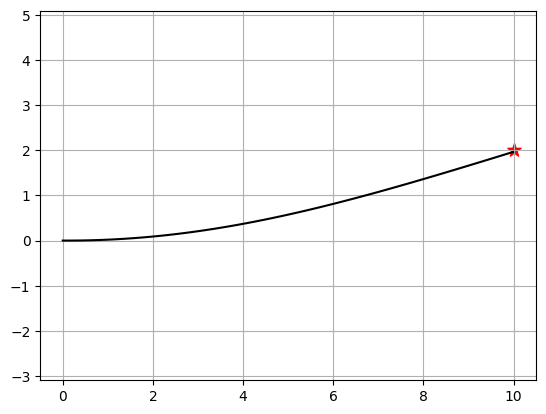

In [38]:
plt.plot(states[:, 0], states[:, 1], c="k")
plt.scatter(goal_state[0], goal_state[1], marker="*", c="r", s=100)
plt.axis("equal")
plt.grid()

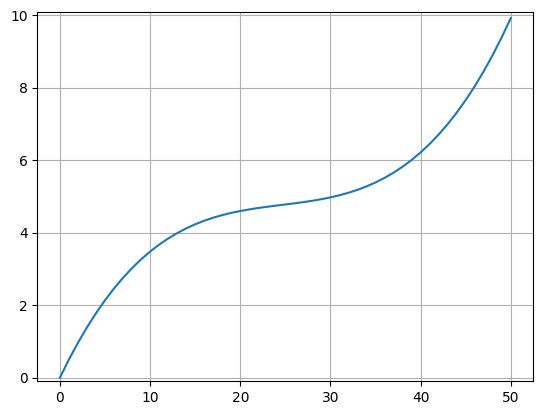

In [27]:
plt.plot(states[:, 0])
plt.ylim([-0.1, 10.1])
plt.grid()

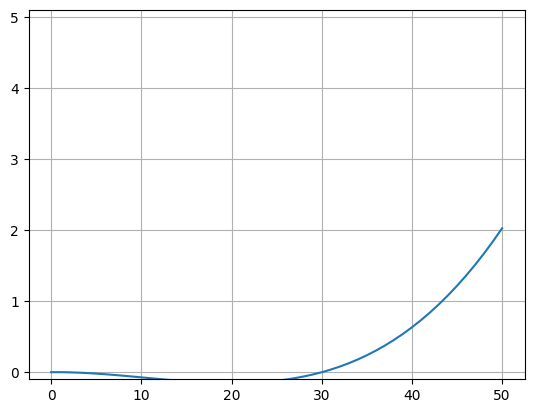

In [28]:
plt.plot(states[:, 1])
plt.ylim([-0.1, 5.1])
plt.grid()

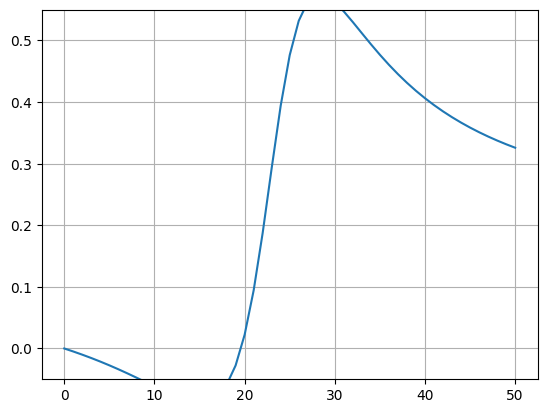

In [29]:
plt.plot(states[:, 2])
plt.ylim([-0.05, 0.55])
plt.grid()

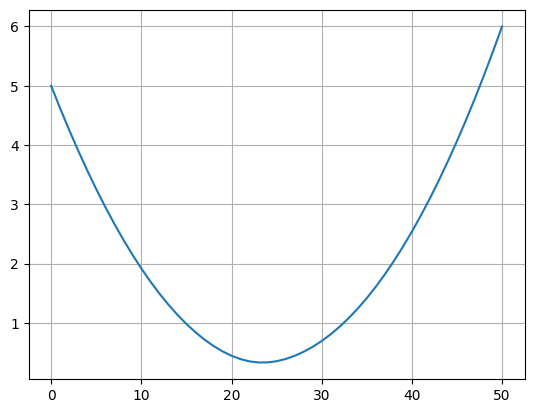

In [30]:
plt.plot(states[:, 3])
plt.grid()